# Distance Ladder I - Resolved Galaxies

To create a distance ladder for our universe, we need to calculate the distances to nearby galaxies that have resolved stars. We can do this by utilising two equally valid and *independent* methods: the period-luminosity relationships we found earlier, and 'Main Sequence' fitting of HR diagrams. 

## Period-Luminosity Distance Estimation

As in the previous workbooks, I'll start by importing the names of resolved galaxies we've identified. 

In [1]:
import os 

datapath = 'Sim Data (Clusters; 800, Seed; 2639)' # all of the data is within a folder in this .ipynb file's directory
GalaxyNames = []
for clusterFile in os.listdir(datapath + '/Star Clusters'):
    GalaxyNames.append(clusterFile[:-4]) # this gets the name of the cluster, without the `.txt' file extension

To begin with, I'll look at the period-luminosity relationship as a means of distance estimation. That is, for all of the variable stars in a galaxy, I'll estimate their intrinsic luminosity and compare that against their observed flux (via the inverse square law) to calculate distance. 

The below code block is quite large, so I'll explain the rationale before we jump into the code. For a given galaxy, we need to identify which stars are variable, and then calculate their variability periods via a Lomb-Scargle periodogram. We can then put those periods into the period-luminosity relationships we found in an earlier workbook to yield the approx. *intrinsic luminosity* of each star. We then compare that with that stars observed flux and obtain the distance to that star as a result. Finally, we can use a statistical trick to ignore outlying data and take the average of the remaining (valid) data points to obtain an estimate for a galaxys distance.

In [2]:
import pandas as pd
import numpy as np
from astropy.timeseries import LombScargle

freqs = np.linspace(1/120, 0.45, 1000)
distance_data = pd.DataFrame({'Name': GalaxyNames})

PL_dists = np.zeros(len(GalaxyNames))
PL_unc = np.zeros(len(GalaxyNames))
for num, name in enumerate(GalaxyNames): # iterate over the identified galaxies
    galaxdata = pd.read_csv(datapath + f'/Star Clusters/{name}.txt', delimiter=' ')
    # now to isolate the variable stars
    variables = galaxdata['Variable?']
    variableindexes = [i for i, x in enumerate(variables) if x == 1]
    variablenames = galaxdata['Name'][variableindexes].to_numpy()
    periods = np.zeros(len(variablenames)) # initialise
    # now calculate the period of each variable star via LS periodogram
    for i, star in enumerate(variablenames):
        photometryData = pd.read_csv(datapath + f"/Variable Star Data/{star}.txt", delimiter=' ')
        
        time, flux = photometryData['Time'], photometryData['NormalisedFlux'] # just extract the columns as variables
        LS = LombScargle(time, flux) # initialize a Lomb-Scargle fitting
        power = LS.power(freqs) # calculate LS power 
        bestfreq = freqs[np.argmax(power)] # which frequency has the highest Lomb-Scargle power?
        pred = LS.model(time, bestfreq) # make a sine wave prediction at the best frequency
        periods[i] = 1 / bestfreq # add each period to the list
        
    intr_lumin = np.zeros(len(periods)) # initialise
    lumin_err = np.zeros(len(periods))
    # time to work out intrinsic luminosities via the PL relations
    for i, period in enumerate(periods): 
        if 20 <= period <= 35:
            intr_lumin[i] = 10**(-0.086 * period + 28.25)
            AB = 0.087 * period * np.sqrt((0.002 / 0.087)**2 + (0.1 / period)**2)
            AB_C = np.sqrt(AB**2 + 0.04**2)
            lumin_err[i] = intr_lumin[i] * (np.log(10) * AB_C)
        if 35 <= period <= 55:
            intr_lumin[i] = 10**(-0.087 * period + 33.72)
            AB = 0.087 * period * np.sqrt((0.002 / 0.087)**2 + (0.1 / period)**2)
            AB_C = np.sqrt(AB**2 + 0.08**2)
            lumin_err[i] = intr_lumin[i] * (np.log(10) * AB_C)
        elif 80 <= period <= 110:
            intr_lumin[i] = 10**(-0.087 * period + 34.35)
            AB = 0.087 * period * np.sqrt((0.001 / 0.087)**2 + (0.1 / period)**2)
            AB_C = np.sqrt(AB**2 + 0.06**2)
            lumin_err[i] = intr_lumin[i] * (np.log(10) * AB_C)
            
    # now to finally compare intr_lumin against the fluxes to obtain distances
    greenFluxes = galaxdata['GreenF'][variableindexes].to_numpy()
    distances = []
    distance_unc = []
    
    if len(intr_lumin) > 10: # we only want to look at galaxies with reasonably high sample size of variables
        for i, lumin in enumerate(intr_lumin):
            if lumin > 0: # this is to avoid noisy data
                distance_m = np.sqrt(lumin / (4 * np.pi * greenFluxes[i]))
                distance_pc = distance_m / (3.086 * 10**16)
                distances.append(distance_pc)
                
                lumin_unc = distance_m**2 * np.sqrt((lumin_err[i] / lumin)**2 + (0.01)**2)
                distance_pc_unc = abs(distance_m * 0.5 * lumin_unc / distance_m**2) / (3.086*10**16)
                distance_unc.append(distance_pc_unc)
        # now we need to remove any (inevitable) outliers from the data
        q1, q3 = np.percentile(distances, [25, 75], interpolation='midpoint')
        IQR = q3 - q1
        # the below checks if the data point is within 2.7 standard deviations of the mean
        upper = q3 + 1.5*IQR
        lower = q1 - 1.5*IQR
        # now we only care about data within 2.7 STDs 
        distances = [dist for dist in distances if lower <= dist <= upper]
        distance_unc = [distance_unc[i] for i, x in enumerate(distances) if lower <= x <= upper]
    PL_dists[num] = np.mean(distances)
    PL_unc[num] = np.mean(distance_unc)

Finally, we can add these distance and uncertainty data as columns in a `pandas` DataFrame so that we can use it and/or save it later.

In [3]:
distance_data['PL_distance'] = PL_dists
distance_data['PL_unc'] = PL_unc

## 'Main Sequence Fitting' Distance Estimation
Another, completely independent method of distance estimation is by adjusting the apparent colour-magnitude curve of a galaxy so that it matches a known curve. That is, if we plot the colour-magnitude diagram of a galaxy's *flux*, we can vertically offset it to match the *luminosity* of a known colour-magnitude diagram. Since flux and luminosity are related by distance (by the inverse square law), we can then use this offset to directly estimate the distance that the galaxy is to us. 

From a previous notebook, we found a colour-magnitude (or Hertzprung-Russell) diagram of our local galaxy in terms of stars' *luminosity* in the green 500nm band. I've calculated and plotted it again below so that we can use this as a benchmark for other galaxies.

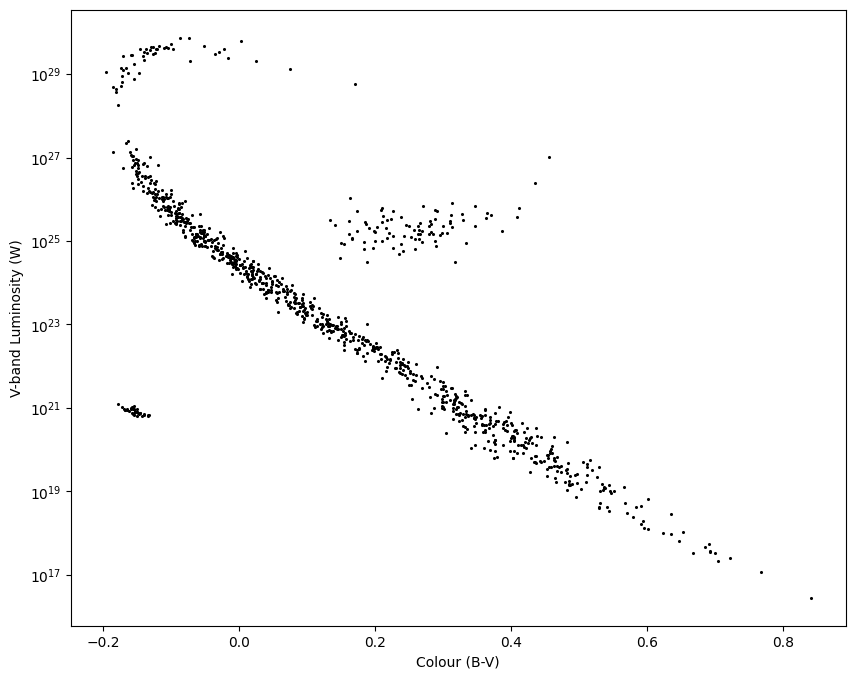

In [4]:
import matplotlib.pyplot as plt

allstardata = pd.read_csv(datapath + '/All Star Data.txt', delimiter=' ')    # read the data from the .txt file into a dataframe

parallax = allstardata['Parallax']    # get the parallax of the stars

localindex = [i for i, x in enumerate(parallax) if x > 0.007]
localVflux = np.array(allstardata["GreenF"])[localindex]
localBflux = np.array(allstardata["BlueF"])[localindex]
BV = np.log10(localVflux / localBflux) # B-V colour index 

localVlumin = localVflux * 4 * np.pi * (1 / np.array(allstardata["Parallax"][localindex]) * 3.086 * 10**16)**2

fig = plt.figure(figsize=(10, 8))   # make a figure to plot stuff on
ax = fig.add_subplot(1, 1, 1)    # and add an axis so we can plot stuff on the figure
ax.scatter(BV, localVlumin, s=1.5, c='k')
ax.set_yscale('log'); ax.set_xlabel('Colour (B-V)'); ax.set_ylabel('V-band Luminosity (W)');

With that out of the way, we can start fitting some galaxies against this benchmark! I'll plot essentially what's happening.

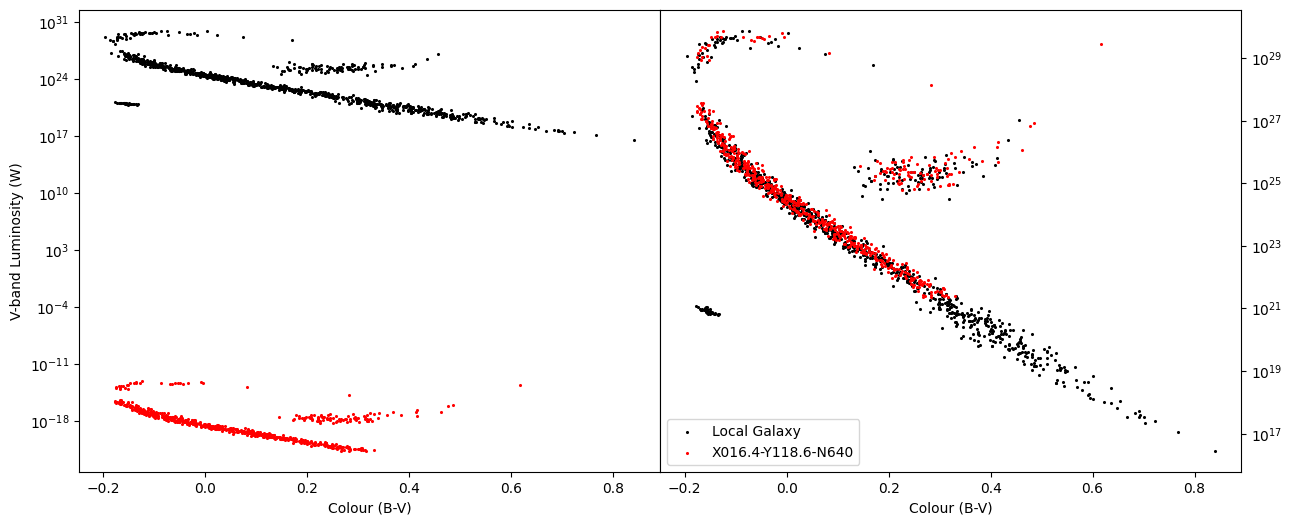

In [5]:
MS_dist = np.zeros(len(GalaxyNames))
MS_unc = np.zeros(len(GalaxyNames))
for num, name in enumerate(GalaxyNames):
    galaxdata = pd.read_csv(datapath + f'/Star Clusters/{name}.txt', delimiter=' ')
    galaxVflux = np.array(galaxdata["GreenF"])
    galaxBflux = np.array(galaxdata["BlueF"])
    galaxBV = np.log10(galaxVflux / galaxBflux) # B-V colour index 
    
    offset = max(np.log10(localVlumin)) - max(np.log10(galaxVflux))
    
    dist_m = np.sqrt(10**offset / (4 * np.pi))
    dist_pc = dist_m / (3.086 * 10**16)
    
    dist_pc_unc = (dist_m**2 * np.log(10) * np.sqrt(2) * 0.01 / (4 * np.pi)) * 0.5 * dist_m / (dist_m**2 * (3.086*10**16))
    
    MS_dist[num] = dist_pc
    MS_unc[num] = dist_pc_unc
    
    if num == 20:
        fig, [ax, ax2] = plt.subplots(1, 2, figsize=(15, 6))
        fig.subplots_adjust(wspace=0)
        
        ax.scatter(galaxBV, galaxVflux, s=1.5, c='r')
        ax.scatter(BV, localVlumin, s=1.5, c='k')
        ax.set_yscale('log'); ax.set_xlabel('Colour (B-V)'); ax.set_ylabel('V-band Luminosity (W)');
        
        ax2.scatter(BV, localVlumin, s=1.5, c='k', label="Local Galaxy")
        ax2.scatter(galaxBV, galaxVflux * 10**offset, s=1.5, c='r', label=f"{GalaxyNames[num]}")
        ax2.yaxis.tick_right(); ax2.yaxis.set_label_position("right")
        ax2.set_yscale('log'); ax2.set_xlabel('Colour (B-V)')
        ax2.legend(loc='lower left')
        
    

In the above plots, we can see that we shift the galaxys values upwards (shown in red) to match the benchmark (shown in black). From this, we can *also* see that some data is no longer available to us - presumably stars that are too dim to resolve at this large distance.

Finally, we can add these distances and their uncertainties to the existing `pandas` DataFrame and save it to the directory. I'll print it, too, so that we can compare some of the values between Period-Luminosity fitting and Main-Sequence fitting.

In [6]:
distance_data['MS_distance'] = MS_dist
distance_data['MS_unc'] = MS_unc
distance_data.to_csv(datapath + '/Galaxy Distances.txt', index=None, sep=' ')

distance_data

,Name,PL_distance,PL_unc,MS_distance,MS_unc
0,X000.7-Y065.4-N610,23166.527455,19449.126986,27581.906457,35.736754
1,X001.3-Y063.9-N1640,14820.848927,3695.503081,6415.994075,8.312943
2,X002.2-Y076.6-N613,6800.865201,650.921293,7548.523170,9.780314
3,X002.4-Y065.4-N781,23709.239488,5975.887750,24263.992024,31.437868
4,X002.6-Y057.3-N842,7480.182488,790.226449,7680.245139,9.950981
...,...,...,...,...,...
388,X354.8-Y077.7-N708,19100.066343,2976.781075,23443.469776,30.374750
389,X355.3-Y074.1-N915,7200.860679,426632.290482,7583.454052,9.825573
390,X355.9-Y077.4-N898,5584.375784,567.988176,5820.374044,7.541222
391,X356.2-Y076.6-N842,18124.891216,2092.807586,19255.655329,24.948769
